In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# --- 1. Load and Prepare Data ---
df = pd.read_csv('usd_exchange_rates.csv')
df['date'] = pd.to_datetime(df['TIME_PERIOD'])
df['value'] = df['OBS_VALUE'].astype(float)
df = df.sort_values('date').reset_index(drop=True)

# Create lag feature (predict t using t-1)
df['value_lag1'] = df['value'].shift(1)
df = df.dropna().reset_index(drop=True)

In [3]:
# --- 2. Split Data (80% train, 20% test) ---
split = int(len(df) * 0.8)
X = df[['value_lag1']]
y = df['value']
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train, dates_test = df['date'][:split], df['date'][split:]

In [4]:
# --- 3. Scale Data ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

In [5]:
param_dist = {
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1],
    'kernel': ['rbf']
}

svr = SVR()
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=10,            # Number of parameter settings to sample
    cv=3,                 # 3-fold CV
    verbose=2,            # Print progress
    n_jobs=-1,            # Use all available CPUs
    random_state=42
)
random_search.fit(X_train_scaled, y_train_scaled)

print("Best SVR parameters found:", random_search.best_params_)

C:\Users\alius\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVR parameters found: {'kernel': 'rbf', 'epsilon': 0.01, 'C': 100}


In [6]:
best_svr = random_search.best_estimator_
y_pred_scaled = best_svr.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

In [7]:
# --- 6. Evaluation Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape_val = mape(y_test, y_pred)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape_val:.2f}%')

MSE: 0.0000
RMSE: 0.0052
MAE: 0.0038
MAPE: 0.35%


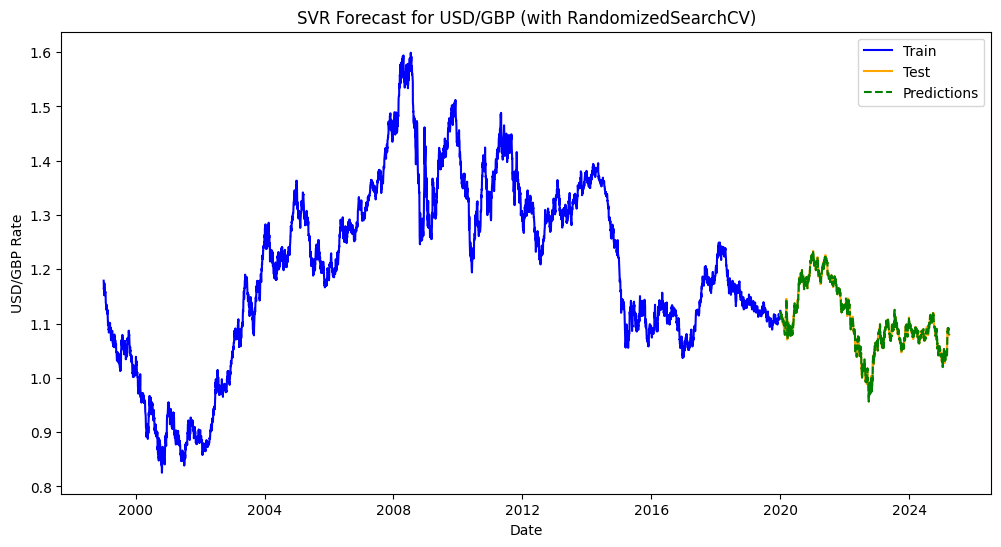

In [8]:
# --- 7. Plot Results ---
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_test, y_test, label='Test', color='orange')
plt.plot(dates_test, y_pred, label='Predictions', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('USD/GBP Rate')
plt.title('SVR Forecast for USD/GBP (with RandomizedSearchCV)')
plt.legend()
plt.show()

In [9]:
# 8. Save SVR predictions + actuals to CSV
output_df = pd.DataFrame({
    'date':       dates_test,
    'actual':     y_test.values,
    'predicted':  y_pred
})

output_df.to_csv('svr_forecast_output.csv', index=False)
print("Forecast data saved to 'svr_forecast_output.csv'")

Forecast data saved to 'svr_forecast_output.csv'
